In [5]:
import exifread
import os

# 1. Setup the filename
filename = 'FLIR0004.jpg' 

# Check if file exists to avoid confusion
if not os.path.exists(filename):
    print(f"Error: Could not find '{filename}' in the current folder.")
    print("Please check the file name and extension (e.g., is it FLIR0004.jpg or just FLIR0004?)")
else:
    print(f"--- Scanning {filename} ---")
    
    with open(filename, 'rb') as f:
        # 2. Process the file
        # details=False skips the huge binary thumbnails/blobs to keep output clean
        tags = exifread.process_file(f, details=False)

        # 3. Print ALL tags found (Use this to find your exact serial number tag)
        print(f"\n[RAW DUMP] Found {len(tags)} tags:")
        for tag_key, tag_value in tags.items():
            # We filter out the unknown binary tags that look like hex codes for readability
            if 'MakerNote' not in tag_key: 
                print(f"   {tag_key}: {tag_value}")

        print("\n" + "="*40)
        
        # 4. Attempt to Extract Specific Data
        # FLIR often uses these keys, but they can vary by firmware version
        print("[EXTRACTION TEST]")
        
        # Model
        model = tags.get('Image Model')
        print(f"Camera Model:   {model}")

        # Serial Number (Check these keys in the RAW DUMP if this says None)
        serial = tags.get('Image BodySerialNumber') or tags.get('EXIF BodySerialNumber') or tags.get('MakerNote SerialNumber')
        print(f"Serial Number:  {serial}")

        # Timestamp
        date = tags.get('EXIF DateTimeOriginal') or tags.get('Image DateTime')
        print(f"Timestamp:      {date}")

--- Scanning FLIR0004.jpg ---

[RAW DUMP] Found 30 tags:
   Image Make: Teledyne FLIR
   Image Model: FLIR E5 Pro
   Image Orientation: Horizontal (normal)
   Image XResolution: 72
   Image YResolution: 72
   Image ResolutionUnit: Pixels/Inch
   Image Software: 1.21.0
   Image DateTime: 2025:11:24 14:31:19
   Image YCbCrPositioning: Centered
   Image ExifOffset: 204
   Thumbnail Compression: JPEG (old-style)
   Thumbnail Orientation: Horizontal (normal)
   Thumbnail XResolution: 72
   Thumbnail YResolution: 72
   Thumbnail ResolutionUnit: Pixels/Inch
   Thumbnail JPEGInterchangeFormat: 1848
   Thumbnail JPEGInterchangeFormatLength: 5191
   EXIF ExifVersion: 0220
   EXIF DateTimeOriginal: 2025:11:24 14:31:19
   EXIF DateTimeDigitized: 2025:11:24 14:31:19
   EXIF ComponentsConfiguration: CrCbY
   EXIF SubjectDistance: 1
   EXIF FocalLength: 13/2
   EXIF FlashPixVersion: 0100
   EXIF ColorSpace: sRGB
   EXIF ExifImageWidth: 640
   EXIF ExifImageLength: 480
   EXIF DigitalZoomRatio: 1
   E

In [17]:
thermal_array[60,81]

np.float32(35.547787)

In [10]:
# Save the full array to a CSV file
# fmt='%.2f' keeps it to 2 decimal places to save space
np.savetxt("thermal_output.csv", thermal_array, delimiter=",", fmt='%.2f')

print("Saved full array to 'thermal_output.csv'")

Saved full array to 'thermal_output.csv'


In [1]:
import subprocess
import json
import os

image_path = "flir ignite sync/100_FLIR/FLIR0020.jpg"

# YOUR SPECIFIC PATH
exiftool_path = "exiftool-12.35.exe"  # Adjust if needed
def export_all_metadata(path, tool_path):
    if not os.path.exists(tool_path):
        print(f"Error: ExifTool not found at {tool_path}")
        return

    try:
        # Command to get EVERYTHING (-j outputs as JSON)
        cmd = [tool_path, "-j", path]
        
        result = subprocess.run(cmd, capture_output=True, text=True)
        
        if not result.stdout:
            print("Error: No data returned.")
            return

        # Parse the data
        all_data = json.loads(result.stdout)[0]
        
        # Save to a file (because it's too big to read in the terminal)
        output_filename = image_path + "_metadata.json"
        with open(output_filename, "w") as f:
            json.dump(all_data, f, indent=4)
            
        print(f"Success! Found {len(all_data)} data points.")
        print(f"Full report saved to: {output_filename}")
        

    except Exception as e:
        print(f"Error: {e}")

# Run it
export_all_metadata(image_path, exiftool_path)

Success! Found 120 data points.
Full report saved to: flir ignite sync/100_FLIR/FLIR0020.jpg_metadata.json


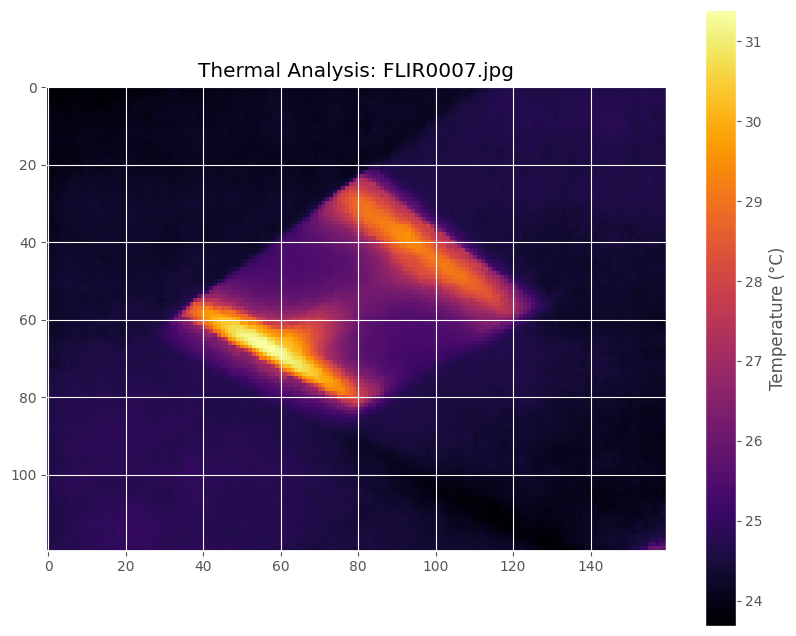

In [5]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 8))
plt.imshow(thermal_array, cmap='inferno') # 'inferno', 'jet', or 'gray' are good colormaps
plt.colorbar(label='Temperature (°C)')
plt.title(f"Thermal Analysis: {image_path}")

# Save the plot as an image
plt.savefig("thermal_heatmap.png")
plt.show()

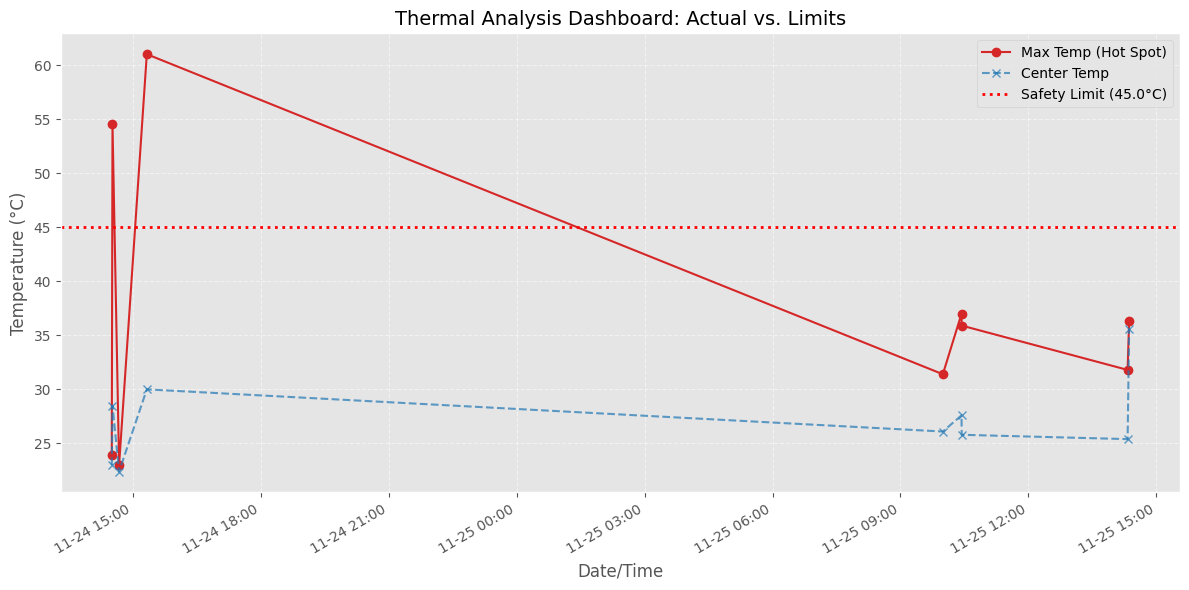

Highest Temp Recorded: 61.0°C
Average Max Temp:      37.20°C
Images exceeding limit: 2


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- CONFIGURATION ---
csv_file = "Batch_Thermal_Report.csv"
SAFE_LIMIT = 45.0  # Example: 45°C is the "Warning" line

try:

    # 1. READ DATA
    df = pd.read_csv(csv_file)
    
    # --- FIX FOR TIMESTAMP PARSING ---
    # Ensure the column is treated as text first
    df['Timestamp'] = df['Timestamp'].astype(str)
    
    # 1. Simplify the string: "2025:11:24 14:30:18.107+02:00" -> "2025:11:24 14:30:18"
    # We split at the "." and take the first part, discarding milliseconds and timezone
    df['Timestamp'] = df['Timestamp'].str.split('.').str[0]
    
    # 2. Parse using the specific FLIR format (Year:Month:Day)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y:%m:%d %H:%M:%S', errors='coerce')

    
    # Drop rows where Timestamp failed to parse
    df = df.dropna(subset=['Timestamp'])
    
    # Sort by time so the line graph connects correctly
    df = df.sort_values(by='Timestamp')

    # 2. CREATE "EXPECTED" DATA
    # Option A: The Fixed Limit
    df['Limit_Temp'] = SAFE_LIMIT
    
    # Option B: The "Delta" Check (How much hotter than the center?)
    # This helps see if a specific spot is burning hot compared to the object average
    df['Excess_Heat'] = df['Max Temp (°C)'] - df['Avg Temp (°C)']

    # 3. PLOT THE DASHBOARD
    plt.figure(figsize=(12, 6))
    
    # Plot 1: The Max Temperature (Actual)
    plt.plot(df['Timestamp'], df['Max Temp (°C)'], 
             marker='o', linestyle='-', color='#d62728', label='Max Temp (Hot Spot)')
    
    # Plot 2: The Center Temperature (Reference)
    plt.plot(df['Timestamp'], df['Center Temp (°C)'], 
             marker='x', linestyle='--', color='#1f77b4', alpha=0.7, label='Center Temp')
    
    # Plot 3: The Limit Line (Expected/Safety)
    plt.axhline(y=SAFE_LIMIT, color='red', linestyle=':', linewidth=2, label=f'Safety Limit ({SAFE_LIMIT}°C)')

    # --- FORMATTING ---
    plt.title('Thermal Analysis Dashboard: Actual vs. Limits', fontsize=14)
    plt.xlabel('Date/Time')
    plt.ylabel('Temperature (°C)')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    
    # Make dates look nice on the X-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.gcf().autofmt_xdate() # Rotate dates so they fit

    # 4. SHOW THE DASHBOARD
    plt.tight_layout()
    plt.show()

    # Optional: Print Statistics
    print(f"Highest Temp Recorded: {df['Max Temp (°C)'].max()}°C")
    print(f"Average Max Temp:      {df['Max Temp (°C)'].mean():.2f}°C")
    print(f"Images exceeding limit: {len(df[df['Max Temp (°C)'] > SAFE_LIMIT])}")

except FileNotFoundError:
    print(f"Error: Could not find {csv_file}")
except Exception as e:
    print(f"An error occurred: {e}")

In [11]:
import os
import csv
import json
import subprocess
import numpy as np
from flirimageextractor import FlirImageExtractor

# --- CONFIGURATION ---
# 1. Get the folder where this script is running
base_dir = os.getcwd()

# 2. Define Input Folder relative to script
input_folder = os.path.join(base_dir, "flir ignite sync", "100_FLIR")
output_csv = "Batch_Thermal_Report.csv"

# 3. Define ExifTool path relative to script
# (Make sure you pasted the .exe file next to this script!)
exiftool_filename = "exiftool-12.35.exe"
exiftool_path = os.path.join(base_dir, exiftool_filename)

# --- HELPER FUNCTIONS ---

def get_metadata_with_exiftool(file_path):
    # Check if the tool exists in the local folder
    if not os.path.exists(exiftool_path):
        # Fallback: Check if 'exiftool' is installed globally in Windows
        if subprocess.run(["where", "exiftool"], capture_output=True).returncode == 0:
            tool_cmd = "exiftool"
        else:
            return {"Error": "ExifTool not found in folder"}
    else:
        tool_cmd = exiftool_path

    try:
        cmd = [
            tool_cmd,
            "-DateTimeOriginal",
            "-CameraModel",
            "-CameraSerialNumber",
            "-Emissivity",
            "-ObjectDistance",
            "-j",
            file_path
        ]
        
        # CREATE_NO_WINDOW prevents the black command box from flashing
        creation_flags = 0
        if os.name == 'nt':  # If running on Windows
            creation_flags = subprocess.CREATE_NO_WINDOW
            
        result = subprocess.run(cmd, capture_output=True, text=True, creationflags=creation_flags)
        
        if result.stdout:
            return json.loads(result.stdout)[0]
    except Exception:
        pass
        
    return {}

def get_processed_files(csv_path):
    processed = set()
    if not os.path.exists(csv_path):
        return processed
    try:
        with open(csv_path, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            next(reader, None)
            for row in reader:
                if row:
                    processed.add(row[0])
    except Exception:
        pass 
    return processed

def process_folder_incremental():
    headers = [
        "File Name", "Timestamp", "Camera Model", "Serial Number", 
        "Center Temp (°C)", "Max Temp (°C)", "Min Temp (°C)", 
        "Avg Temp (°C)", "Delta Temp (°C)", 
        "Emissivity", "Distance", "Status"
    ]
    
    # Validation Checks
    if not os.path.exists(input_folder):
        print(f"Error: Input folder not found at:\n{input_folder}")
        return

    if not os.path.exists(exiftool_path):
        print(f"WARNING: {exiftool_filename} not found in current directory.")
        print(f"Please copy the .exe file to: {base_dir}")
        print("Continuing... (Metadata might fail)")

    # 1. IDENTIFY WORK
    all_files = [f for f in os.listdir(input_folder) if f.lower().endswith(".jpg")]
    processed_files = get_processed_files(output_csv)
    files_to_process = [f for f in all_files if f not in processed_files]
    
    print(f"Total Images: {len(all_files)}")
    print(f"Already Done: {len(processed_files)}")
    print(f"New to Process: {len(files_to_process)}")
    
    if not files_to_process:
        print("Nothing new to add. Exiting.")
        return

    # 2. PREPARE CSV
    file_exists = os.path.exists(output_csv)
    
    with open(output_csv, mode='a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(headers)
        
        # 3. PROCESS LOOP
        for i, filename in enumerate(files_to_process):
            full_path = os.path.join(input_folder, filename)
            print(f"Processing [{i+1}/{len(files_to_process)}]: {filename}", end="\r")
            
            try:
                # --- A. Thermal Data ---
                flir = FlirImageExtractor()
                flir.process_image(full_path)
                thermal_data = flir.get_thermal_np()
                
                min_t = np.min(thermal_data)
                max_t = np.max(thermal_data)
                avg_t = np.mean(thermal_data)
                delta_t = max_t - min_t
                
                h, w = thermal_data.shape
                center_t = thermal_data[h//2, w//2]
                
                # --- B. Metadata (Relative ExifTool) ---
                meta = get_metadata_with_exiftool(full_path)
                
                # Check for error if exiftool was missing
                if "Error" in meta:
                    serial = "Error: ExifTool Missing"
                else:
                    serial = meta.get("CameraSerialNumber", "Unknown")

                timestamp = meta.get("DateTimeOriginal", "Unknown")
                camera_model = meta.get("CameraModel", "Unknown")
                emissivity = meta.get("Emissivity", "N/A")
                distance = meta.get("ObjectDistance", "N/A")
                
                # --- C. Write Row ---
                writer.writerow([
                    filename, timestamp, camera_model, serial, 
                    f"{center_t:.1f}", f"{max_t:.1f}", f"{min_t:.1f}", 
                    f"{avg_t:.1f}", f"{delta_t:.1f}", 
                    emissivity, distance, "Success"
                ])
                
            except Exception as e:
                writer.writerow([filename, "", "", "", "", "", "", "", "", "", "", f"Error: {str(e)}"])

    print(f"\n\nDone! Added {len(files_to_process)} rows to: {output_csv}")

if __name__ == "__main__":
    process_folder_incremental()
    input("Press Enter to exit...")

Total Images: 9
Already Done: 0
New to Process: 9
File paths successfully generated:
DIRP: c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\dji_executables\dji_thermal_sdk_v1.7\windows/release_x64/libdirp.dll
DIRP Sub: c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\dji_executables\dji_thermal_sdk_v1.7\windows/release_x64/libv_dirp.dll
IIRP: c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\dji_executables\dji_thermal_sdk_v1.7\windows/release_x64/libv_iirp.dll
ExifTool: c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\dji_executables\dji_thermal_sdk_v1.7\exiftool-12.35.exe
File paths successfully generated:
DIRP: c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\dji_executables\dji_thermal_sdk_v1.7\windows/release_x64/libdirp.dll
DIRP Sub: c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\dji_executables\dji_thermal_sdk_v1.7\windows/release

In [21]:
import os
import csv
import json
import subprocess
import numpy as np
import contextlib
import sys
from flirimageextractor import FlirImageExtractor

# --- CONFIGURATION ---

# 1. SMART PATH FINDER (Works in both .py and .ipynb)
try:
    # Try getting the path using __file__ (works for .py scripts)
    base_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # If that fails (Jupyter Notebooks), just use the current working directory
    base_dir = os.getcwd()

# 2. Define folders
input_folder = os.path.join(base_dir, "flir ignite sync", "100_FLIR")
output_csv = os.path.join(base_dir, "Batch_Thermal_Report.csv")

# 3. ExifTool Path
exiftool_filename = "exiftool-12.35.exe"
exiftool_path = os.path.join(base_dir, exiftool_filename)

# --- HELPER FUNCTIONS ---

def get_metadata_with_exiftool(file_path):
    if not os.path.exists(exiftool_path):
        tool_cmd = "exiftool"
    else:
        tool_cmd = exiftool_path

    try:
        cmd = [
            tool_cmd,
            "-DateTimeOriginal",
            "-CameraModel",
            "-CameraSerialNumber",
            "-Emissivity",
            "-ObjectDistance",
            "-j",
            file_path
        ]
        
        creation_flags = 0
        if os.name == 'nt': 
            creation_flags = subprocess.CREATE_NO_WINDOW
            
        result = subprocess.run(cmd, capture_output=True, text=True, creationflags=creation_flags)
        
        if result.stdout:
            return json.loads(result.stdout)[0]
    except Exception:
        pass
    return {}

def get_processed_files(csv_path):
    processed = set()
    if not os.path.exists(csv_path):
        return processed
    try:
        with open(csv_path, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            next(reader, None)
            for row in reader:
                if row:
                    processed.add(row[0])
    except Exception:
        pass 
    return processed

def process_folder_incremental():
    headers = [
        "File Name", "Timestamp", "Camera Model", "Serial Number", 
        "Center Temp (°C)", "Max Temp (°C)", "Min Temp (°C)", 
        "Avg Temp (°C)", "Delta Temp (°C)", 
        "Emissivity", "Distance", "Status"
    ]
    
    # Validation Checks
    if not os.path.exists(input_folder):
        print(f"Error: Input folder not found at:\n{input_folder}")
        print(f"(Looking in base dir: {base_dir})")
        return

    # 1. IDENTIFY WORK
    all_files = [f for f in os.listdir(input_folder) if f.lower().endswith(".jpg")]
    processed_files = get_processed_files(output_csv)
    files_to_process = [f for f in all_files if f not in processed_files]
    
    print(f"Total Images: {len(all_files)}")
    print(f"Already Done: {len(processed_files)}")
    print(f"New to Process: {len(files_to_process)}")
    
    if not files_to_process:
        print("Nothing new to add. Exiting.")
        return

    # 2. INITIALIZE FLIR TOOL (SILENTLY)
    print("Initializing FLIR Extractor...", end="\r")
    try:
        with contextlib.redirect_stdout(None):
            flir = FlirImageExtractor()
    except Exception as e:
        print(f"\nError initializing FLIR extractor: {e}")
        return

    # 3. PREPARE CSV (Handle Permission Errors)
    file_exists = os.path.exists(output_csv)
    
    try:
        f = open(output_csv, mode='a', newline='', encoding='utf-8')
    except PermissionError:
        print(f"\n\nERROR: Permission Denied for '{output_csv}'")
        print(">>> PLEASE CLOSE THE CSV FILE IN EXCEL AND TRY AGAIN. <<<")
        return
    except Exception as e:
        print(f"\nError opening CSV: {e}")
        return

    # Use 'with' to ensure file closes even if script crashes
    with f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(headers)
        
        # 4. PROCESS LOOP
        for i, filename in enumerate(files_to_process):
            full_path = os.path.join(input_folder, filename)
            
            # Progress Bar
            print(f"Processing [{i+1}/{len(files_to_process)}]: {filename}" + " "*20, end="\r")
            
            try:
                # --- A. Thermal Data ---
                with contextlib.redirect_stdout(None):
                    flir.process_image(full_path)
                    
                thermal_data = flir.get_thermal_np()
                
                min_t = np.min(thermal_data)
                max_t = np.max(thermal_data)
                avg_t = np.mean(thermal_data)
                delta_t = max_t - min_t
                h, w = thermal_data.shape
                center_t = thermal_data[h//2, w//2]
                
                # --- B. Metadata ---
                meta = get_metadata_with_exiftool(full_path)
                
                serial = meta.get("CameraSerialNumber", "Unknown")
                timestamp = meta.get("DateTimeOriginal", "Unknown")
                camera_model = meta.get("CameraModel", "Unknown")
                emissivity = meta.get("Emissivity", "N/A")
                distance = meta.get("ObjectDistance", "N/A")
                
                # --- C. Write Row ---
                writer.writerow([
                    filename, timestamp, camera_model, serial, 
                    f"{center_t:.1f}", f"{max_t:.1f}", f"{min_t:.1f}", 
                    f"{avg_t:.1f}", f"{delta_t:.1f}", 
                    emissivity, distance, "Success"
                ])
                
                # Force save immediately so data isn't lost if script crashes
                f.flush()
                
            except Exception as e:
                writer.writerow([filename, "", "", "", "", "", "", "", "", "", "", f"Error: {str(e)}"])

    print(f"\n\nDone! Added {len(files_to_process)} rows to: {output_csv}")

if __name__ == "__main__":
    try:
        process_folder_incremental()
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")

Total Images: 9
Already Done: 9
New to Process: 0
Nothing new to add. Exiting.


In [3]:
import socket

# Your Camera IP
CAMERA_IP = "192.168.43.72"

# Specific FLIR UDP Data Ports
# 24272: Common for GigE Vision / GenICam (Raw Data)
# 22144: Common for FLIR Config
# 554: RTSP Video
UDP_PORTS = [24272, 22144, 554, 67, 50000, 3956]

print(f"Scanning UDP Ports on {CAMERA_IP}...")

for port in UDP_PORTS:
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.settimeout(1.5)
    
    try:
        # Send a "Discovery" packet (GVCP or FLIR Ping)
        # This specific hex code asks: "Are you there?"
        msg = b'\x00\x00\x00\x00' 
        
        sock.sendto(msg, (CAMERA_IP, port))
        data, addr = sock.recvfrom(1024)
        
        print(f"✅ UDP Port {port} is OPEN! (Received response)")
        
    except socket.timeout:
        print(f"❌ UDP Port {port}: No response")
    except Exception as e:
        print(f"⚠️ Error on {port}: {e}")
    finally:
        sock.close()

Scanning UDP Ports on 192.168.43.72...
❌ UDP Port 24272: No response
❌ UDP Port 22144: No response
❌ UDP Port 554: No response
❌ UDP Port 67: No response
❌ UDP Port 50000: No response
⚠️ Error on 3956: [WinError 10054] An existing connection was forcibly closed by the remote host


In [6]:
import subprocess
import json
import os
import io
import shutil
from PIL import Image, ImageDraw
from pyzbar.pyzbar import decode

# --- CONFIGURATION ---
# Adjust this to point to your specific test image
TEST_IMAGE = "flir ignite sync/100_FLIR/FLIR0025.jpg"

# Path to ExifTool (Update if necessary)
EXIFTOOL_PATH = "exiftool-12.35.exe"

# --- HELPER: WINDOWS PROCESS FLAGS ---
def get_process_flags():
    """Returns flags to prevent black command window popping up on Windows."""
    if os.name == 'nt':
        return subprocess.CREATE_NO_WINDOW
    return 0

# --- PART 1: NOTE EXTRACTOR ---
def get_image_note(file_path):
    """
    Extracts the 'ImageDescription' or 'UserComment' note from a FLIR image.
    """
    print(f"--- Checking for Notes/Metadata ---")
    
    try:
        cmd = [
            EXIFTOOL_PATH,
            "-ImageDescription",
            "-UserComment", 
            "-j",                # Output as JSON
            file_path
        ]
        
        result = subprocess.run(
            cmd, 
            capture_output=True, 
            text=True, 
            creationflags=get_process_flags()
        )

        if result.stdout:
            data = json.loads(result.stdout)
            if not data:
                return None
            
            meta = data[0]
            
            # Try ImageDescription first, then UserComment
            note = meta.get("ImageDescription")
            if not note:
                note = meta.get("UserComment")
            
            if note:
                return str(note).strip()
                
    except Exception as e:
        print(f"Error extracting note: {e}")
        
    return None

# --- PART 2: QR CODE DETECTOR ---
def get_qr_code(file_path):
    """
    Extracts the visual embedded image and scans for QR codes.
    Returns a list of decoded strings.
    """
    print(f"\n--- Checking for QR Codes ---")
    print(f"1. Extracting visual image from FLIR file...")

    try:
        # Extract the embedded visual image (binary)
        cmd = [EXIFTOOL_PATH, "-b", "-EmbeddedImage", file_path]
        
        result = subprocess.run(
            cmd, 
            capture_output=True,
            creationflags=get_process_flags()
        )
        
        if not result.stdout:
            print("   > Error: No EmbeddedImage found (Are you sure this is a FLIR JPG?).")
            return []

        # Load bytes into Pillow
        image = Image.open(io.BytesIO(result.stdout))
        print(f"   > Embedded image extracted ({image.size[0]}x{image.size[1]} px).")

        print("2. Scanning image for QR data...")
        decoded_objects = decode(image)

        found_data = []

        if not decoded_objects:
            print("   > RESULT: No QR Code detected.")
            # Optional: Show image to debug why
            # image.show() 
        else:
            draw = ImageDraw.Draw(image)
            for obj in decoded_objects:
                code_data = obj.data.decode("utf-8")
                code_type = obj.type
                found_data.append(f"[{code_type}] {code_data}")
                
                # Draw box
                rect = obj.rect
                draw.rectangle(
                    [(rect.left, rect.top), (rect.left + rect.width, rect.top + rect.height)],
                    outline="red", width=5
                )
            
            print(f"   > SUCCESS! Found {len(found_data)} code(s).")
            print("   > Opening image with highlighted code...")
            image.show()

        return found_data

    except Exception as e:
        print(f"Error extracting QR: {e}")
        return []

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # 1. Verify ExifTool Exists
    if not os.path.exists(EXIFTOOL_PATH) and shutil.which("exiftool") is None:
        print(f"CRITICAL ERROR: ExifTool not found at '{EXIFTOOL_PATH}'")
        sys.exit(1)

    # 2. Verify Image Exists
    if os.path.exists(TEST_IMAGE):
        print(f"PROCESSING: {TEST_IMAGE}\n" + "="*40)
        
        # --- RUN STEP 1: NOTES ---
        note_text = get_image_note(TEST_IMAGE)
        if note_text:
            print(f"NOTE FOUND: '{note_text}'")
        else:
            print("NOTE STATUS: No text note found.")

        # --- RUN STEP 2: QR CODES ---
        qr_codes = get_qr_code(TEST_IMAGE)
        
        print("\n" + "="*40)
        print("FINAL SUMMARY:")
        print(f"1. Note: {note_text if note_text else 'N/A'}")
        if qr_codes:
            print(f"2. QR/Barcodes Found:")
            for code in qr_codes:
                print(f"   - {code}")
        else:
            print("2. QR/Barcodes: None")
            
    else:
        print(f"Error: Test file not found at: {TEST_IMAGE}")

PROCESSING: flir ignite sync/100_FLIR/FLIR0025.jpg
--- Checking for Notes/Metadata ---
NOTE STATUS: No text note found.

--- Checking for QR Codes ---
1. Extracting visual image from FLIR file...
   > Embedded image extracted (640x480 px).
2. Scanning image for QR data...
   > RESULT: No QR Code detected.

FINAL SUMMARY:
1. Note: N/A
2. QR/Barcodes: None
